# **Set Up**

  We'll be using the Kaggle dataset API to download our images and Google Drive to store them, so the first several lines are just a bit of maintenance and prep work do that. We performed our work in Google Colab, as it offers hosted GPUs that make CNN training much, much faster, and some of that prep work is also contained in the first few lines.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mcn9284","key":"86a8a5f625a901c2d5e685a9c20c777f"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:15<00:00, 172MB/s]
100% 2.29G/2.29G [00:15<00:00, 158MB/s]


In [6]:
! unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
# Importing necessary libraries
from IPython.core.interactiveshell import InteractiveShell
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomContrast, RandomBrightness, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = 'all'

In [8]:
# Mounting Google Drive
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


# **Data Understanding**


  Our data is stored in directory "chest x_ray" and is further subdivided into three subdirectories--train, val, and test. Each of those is further divided into 'NORMAL' and 'PNEUMONIA' folders. The data itself consists of jpeg images of X-Rays from both patients with and without pneumonia.

  Generally speaking, pneumonia presents on radiograph as areas of diffuse opacity (sometimes called 'ground glass opacity') which represents areas of fluid accumulation in and around the alveoli. This fluid is created by the immune system in an attempt to rid the body of the bacterial or viral invader, and has the unfortunate side-effect of lowering the lungs' ability to exchange oxygen and carbon dioxide. Needless to say, not a good thing.

  Our task is to create a convoluted neural network that can read these radiographs and classify them into either 'normal' or 'pneumonia' categories.

# **Preprocessing**

  We will first create paths to each folder of images, and create our data using generators from those directories. 
  We then associate the labels and images and collapse them into two variables (X for images, y for labels) so we can create a better proportioned train-test-split.

In [9]:
# Path to data
from pathlib import Path
data_dir = Path('chest_xray/')


# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [10]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    batch_size=5216)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    batch_size=624)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    batch_size=16)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
train_img, train_labels = next(train_generator)
test_img, test_labels = next(test_generator)
val_img, val_labels = next(val_generator)

In [12]:
tr_y = np.reshape(train_labels[:,0], (5216,1))
te_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [13]:
X = np.concatenate((train_img, test_img, val_img))
y = np.concatenate((tr_y, te_y, val_y))

Let's get a sense of what we're working with. First we will visualize our class balance, then we will take a look at several images from each class.

Since we've got a bit of an imbalance here, we will work out the class weights, assign them appropriately, and include them in our parameters later on when we configure our neural networks.

<BarContainer object of 2 artists>

Text(0, 0.5, '# Xray Images')

([0, 1], <a list of 2 Text major ticklabel objects>)

Pneumonia:  4273
Normal:  1583


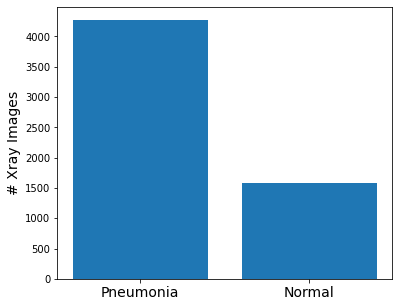

In [14]:
counts = np.unique(y, return_counts=True)[1]
fig, ax = plt.subplots(figsize=(6, 5))
plt.bar(['Pneumonia', 'Normal'], counts)
plt.ylabel('# Xray Images', fontsize=14)
plt.xticks(fontsize=14)
print("Pneumonia: ", counts[0])
print("Normal: ", counts[1])

In [15]:
def class_weights(n, nj):
    return n / (2 * nj)

In [16]:
class_weights(5856, 4273)
print()
class_weights(5856, 1583)

0.6852328574771823

1.8496525584333543

In [17]:
pneumonia_weights = print(
    'weight class 1: ', round(class_weights(5856, 4273), 2))
normal_weights = print('weight class 0: ', round(class_weights(5856, 1583), 2))

weight class 1:  0.69
weight class 0:  1.85


In [18]:
class_weight = {0:0.69, 1:1.85}

Now lets have a look at some of the xrays.

First we'll put the images and their associated labels into a Dataframe, and from there select five randomly from each class



In [19]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# List all normal and pneumonia images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# Create empty list
train_data = []

# Label normal images 0
for img in normal_cases:
    train_data.append((img, 0))

# Label pneumonia images 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Create dataframe with image and label data
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Inspect dataframe
train_data.head()

,image,label
0,chest_xray/train/PNEUMONIA/person1683_bacteria...,1
1,chest_xray/train/PNEUMONIA/person707_virus_130...,1
2,chest_xray/train/PNEUMONIA/person718_virus_131...,1
3,chest_xray/train/PNEUMONIA/person759_bacteria_...,1
4,chest_xray/train/PNEUMONIA/person337_bacteria_...,1


Text(0.5, 1.0, 'Pneumonia')

(-0.5, 2071.5, 1439.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 1747.5, 1201.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 708.5, 499.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 1063.5, 735.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 855.5, 615.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1527.5, 1012.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1715.5, 1201.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1441.5, 1151.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1411.5, 1065.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1417.5, 1120.5, -0.5)

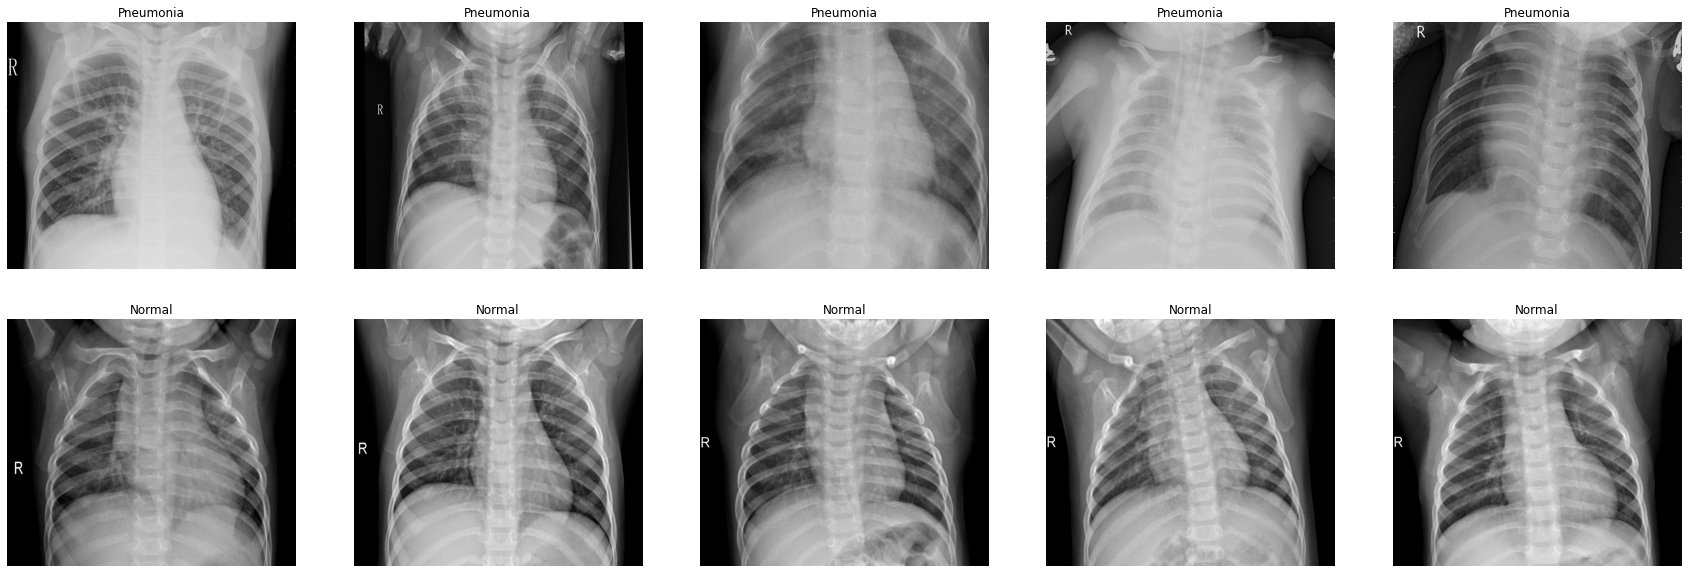

In [20]:
from skimage.io import imread

# Create lists of the first five rows in each class
pneumonia_samples = (
    train_data[train_data['label'] == 1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']
                  == 0]['image'].iloc[:5]).tolist()

# Concatenate and delete the two lists
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot data
f, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("Pneumonia")
    else:
        ax[i//5, i % 5].set_title("Normal")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

There are definite differences between the two classes visually, with pneumonia xrays showing the characteristic 'ground glass opacity'. There are a few cases that, at least to the untrained eye, appear to be ambiguous. Hopefully our model can pick up on features we can't.

The last step of our preprocessing process is to split our data. Recall just a bit ago that we collapsed all the images and labels into X and y variables without respect to test or validation datasets. The idea was that, since the data had been apportioned so awfully, we'd bypass that dumpster fire and split the data in a way that's easier to work with. 

We use a train_test_split, set the test_size to 20% of the total data, and shuffle!

Then of course we check the shape of our splits.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, random_state=42)

In [22]:
print('Training Shape: ', X_train.shape)
print("Test Shape: ", X_test.shape)

Training Shape:  (4684, 256, 256, 3)
Test Shape:  (1172, 256, 256, 3)


In [54]:
keras.backend.clear_session()

# **Modeling**

Our baseline model will start with one convolution/pooling layer, flattened into a 32 unit fully connected layer, which feeds into an output layer with sigmoid activation.

Our conv layer has a filter size of 5x5 because we want the network to have a larger receptive field and to pick up on more general features (at least to start!). 

We use an adam optimizer with learning rate set at 0.0001.

## **Model 1**

In [24]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.001, mode='min',patience=10)

In [25]:
cnn1 = keras.Sequential()

cnn1.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn1.add(layers.MaxPooling2D(2, 2))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(32, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-4)
cnn1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [26]:
cnn1.build(input_shape=(None, 256, 256, 3))
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 32)                4064288   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,064,929
Trainable params: 4,064,929
Non-trainable params: 0
______________________________________________

In [28]:
history1 = cnn1.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    class_weight=class_weight,
                    validation_split=0.20,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100
59/59 [==============================] - 2s 39ms/step - loss: 0.5387 - accuracy: 0.7307 - val_loss: 0.2518 - val_accuracy: 0.9136
Epoch 2/100
59/59 [==============================] - 1s 24ms/step - loss: 0.2754 - accuracy: 0.8916 - val_loss: 0.1876 - val_accuracy: 0.9210
Epoch 3/100
59/59 [==============================] - 1s 24ms/step - loss: 0.2177 - accuracy: 0.9189 - val_loss: 0.1583 - val_accuracy: 0.9530
Epoch 4/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1760 - accuracy: 0.9311 - val_loss: 0.1467 - val_accuracy: 0.9594
Epoch 5/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1570 - accuracy: 0.9416 - val_loss: 0.1650 - val_accuracy: 0.9445
Epoch 6/100
59/59 [==============================] - 1s 25ms/step - loss: 0.1592 - accuracy: 0.9394 - val_loss: 0.1209 - val_accuracy: 0.9562
Epoch 7/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1443 - accuracy: 0.9506 - val_loss: 0.1860 - val_accuracy: 0.9285
Epoch 

The following two functions allow us to evaluate our models as we progress.

The first plots our train and validation loss and accuracies over epoch.

The second generates a confusion matrix to make up for some of the deficiencies presented by accuracy as a metric.

In [29]:
def learn_curves(history):
   # get history of model
    history_dict = history.history

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # define accruacy and loss values
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    # set x range
    epochs = range(1, len(acc_values) + 1)

    # plot accuracy for training and validation
    ax[0].plot(epochs, acc_values, label='Training acc')
    ax[0].plot(epochs, val_acc_values, label='Validation acc')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # plot loss for training and validation
    ax[1].plot(epochs, loss_values, label='Training loss')
    ax[1].plot(epochs, val_loss_values, label='Validation loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    print("Final Training Accuracy:", acc_values[-1])
    print("Final Validation Accuracy:", val_acc_values[-1])

In [30]:
def evaluation(model):
    predictions = (model.predict(X_test) > 0.5)*1
    cm = confusion_matrix(y_test, predictions)

    df_cm = pd.DataFrame(cm.T, index=['Pneumonia', 'Normal'],
                         columns=['Pneumonia', 'Normal'])
    sns.heatmap(df_cm.T, annot=True, fmt='d', cmap='Blues',
                linecolor='black', linewidths=1)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.ylim(0, 2)
    plt.xlim(2, 0)
    plt.show()

    print(model.evaluate(X_test, y_test))

Final Training Accuracy: 0.9951961636543274
Final Validation Accuracy: 0.9573105573654175


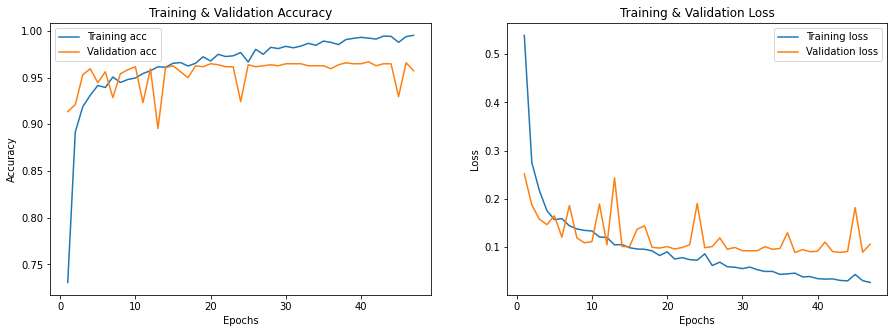

In [31]:
learn_curves(history1)

37/37 [==============================] - 1s 13ms/step


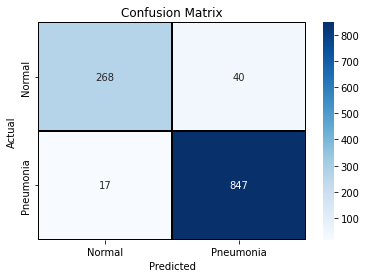

37/37 [==============================] - 0s 9ms/step - loss: 0.1349 - accuracy: 0.9514
[0.13493643701076508, 0.9513651728630066]


In [32]:
evaluation(cnn1)

So, clearly we have some overfitting. We will introduce a regularization term on the conv layer and see if we can get that under some control. 

Overfitting aside, these are encouraging results!

##  **Model 2**

In [39]:
cnn2 = keras.Sequential()

cnn2.add(layers.Conv2D(8, (5, 5), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(256, 256, 3)))
cnn2.add(layers.MaxPooling2D(2, 2))

cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dense(units=1, activation='sigmoid'))


opt = keras.optimizers.Adam(learning_rate=4e-4)
cnn2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn2.build(input_shape=(None, 256, 256, 3))
cnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 32)                4064288   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,064,929
Trainable params: 4,064,929
Non-trainable params: 0
______________________________________________

In [40]:
history2 = cnn2.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    class_weight=class_weight,
                    validation_split=0.20,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100
59/59 [==============================] - 2s 32ms/step - loss: 0.8343 - accuracy: 0.7313 - val_loss: 0.3165 - val_accuracy: 0.9082
Epoch 2/100
59/59 [==============================] - 1s 24ms/step - loss: 0.2507 - accuracy: 0.9258 - val_loss: 0.1924 - val_accuracy: 0.9413
Epoch 3/100
59/59 [==============================] - 1s 24ms/step - loss: 0.2032 - accuracy: 0.9429 - val_loss: 0.1680 - val_accuracy: 0.9530
Epoch 4/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1688 - accuracy: 0.9573 - val_loss: 0.2005 - val_accuracy: 0.9445
Epoch 5/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1640 - accuracy: 0.9578 - val_loss: 0.1737 - val_accuracy: 0.9456
Epoch 6/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1421 - accuracy: 0.9642 - val_loss: 0.1670 - val_accuracy: 0.9562
Epoch 7/100
59/59 [==============================] - 1s 24ms/step - loss: 0.1346 - accuracy: 0.9685 - val_loss: 0.1490 - val_accuracy: 0.9616
Epoch 

Final Training Accuracy: 0.9997330904006958
Final Validation Accuracy: 0.965848445892334


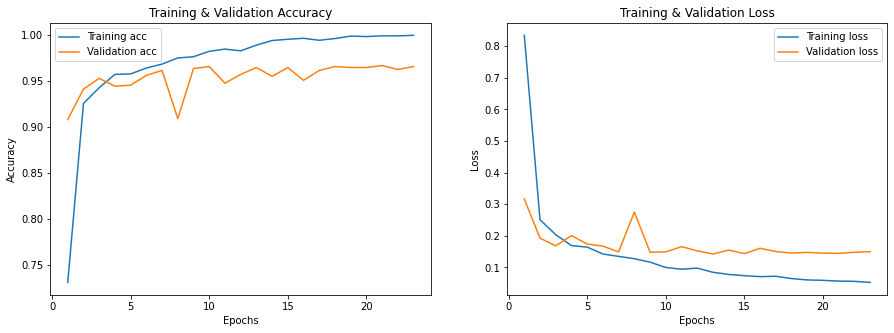

In [41]:
learn_curves(history2)

37/37 [==============================] - 0s 8ms/step


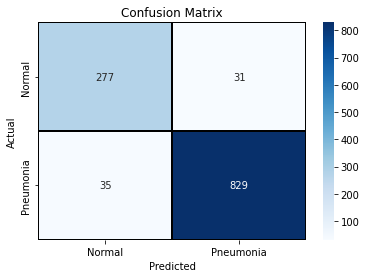

37/37 [==============================] - 0s 9ms/step - loss: 0.1937 - accuracy: 0.9437
[0.19369034469127655, 0.9436860084533691]


In [42]:
evaluation(cnn2)

The l2 regularization helped, but we went a little light in our efforts. 

So we are gonna do a couple of things. First, and this won't help with the fit, we will increase the complexity of the model and lower the learning rate to hopefully speed things up a bit.

We will introduce regularization on each conv block and include a dropout layer just before the classifier. The dropout is set at 0.50.

##  **Model 3**

In [43]:
cnn3 = keras.Sequential()

cnn3.add(layers.Conv2D(8, 5, activation='relu', input_shape=(256, 256, 3)))
cnn3.add(layers.Conv2D(16, 3, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn3.add(layers.MaxPooling2D(2, 2))

cnn3.add(layers.Conv2D(16, 3, activation='relu'))
cnn3.add(layers.Conv2D(32, 3, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn3.add(layers.MaxPooling2D(2, 2))

cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dropout(0.5))
cnn3.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(1e-5)
cnn3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn3.build(input_shape=(None, 256, 256, 3))
cnn3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 252, 252, 8)       608       
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 121, 121, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [45]:
history3 = cnn3.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100
59/59 [==============================] - 4s 57ms/step - loss: 0.9808 - accuracy: 0.6258 - val_loss: 0.9593 - val_accuracy: 0.7161
Epoch 2/100
59/59 [==============================] - 2s 37ms/step - loss: 0.8876 - accuracy: 0.7814 - val_loss: 0.7856 - val_accuracy: 0.8922
Epoch 3/100
59/59 [==============================] - 2s 37ms/step - loss: 0.8010 - accuracy: 0.8335 - val_loss: 0.7565 - val_accuracy: 0.8677
Epoch 4/100
59/59 [==============================] - 2s 38ms/step - loss: 0.7381 - accuracy: 0.8481 - val_loss: 0.6710 - val_accuracy: 0.8965
Epoch 5/100
59/59 [==============================] - 2s 38ms/step - loss: 0.6924 - accuracy: 0.8594 - val_loss: 0.6537 - val_accuracy: 0.8709
Epoch 6/100
59/59 [==============================] - 2s 37ms/step - loss: 0.6508 - accuracy: 0.8650 - val_loss: 0.5829 - val_accuracy: 0.9157
Epoch 7/100
59/59 [==============================] - 2s 37ms/step - loss: 0.6186 - accuracy: 0.8770 - val_loss: 0.5777 - val_accuracy: 0.9018
Epoch 

Final Training Accuracy: 0.9482252597808838
Final Validation Accuracy: 0.942369282245636


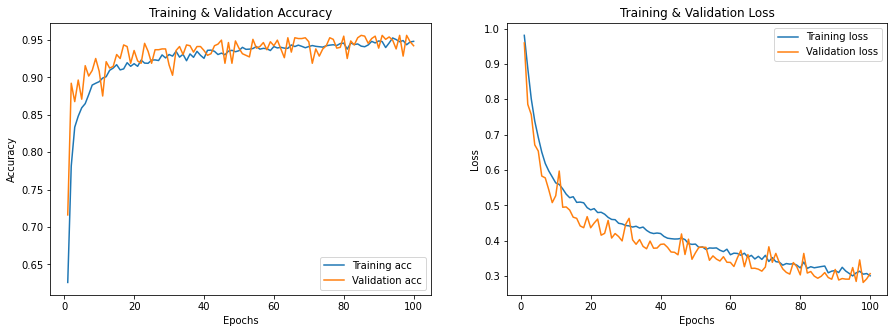

In [46]:
learn_curves(history3)

37/37 [==============================] - 0s 11ms/step


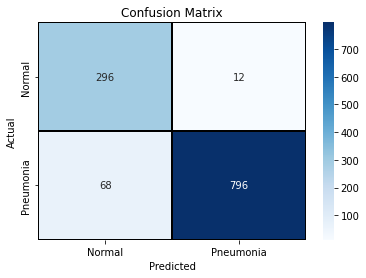

37/37 [==============================] - 0s 12ms/step - loss: 0.3408 - accuracy: 0.9317
[0.34081757068634033, 0.9317406415939331]


In [47]:
evaluation(cnn3)

That is looking a lot better. The fit looks fine now, but the model still seems a bit slow to converge. It's also rather noisy. 

We will increase the complexity again, but limit our regularization to the dense layers, of which there are now two. 

Another good way to keep overfitting in check is to introduce more data. For this we're adding a preprocessing layer that randomly tweaks the image contrast. Given the nature of X-ray imagery, this could be draw out new features or mask unimportant ones.

## **Model 4**

In [48]:
cnn4 = keras.Sequential()

cnn4.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn4.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn4.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D(2, 2))

cnn4.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D(2, 2))

cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(32, activation='relu'))
cnn4.add(layers.Dropout(0.4))
cnn4.add(layers.Dense(64, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn4.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(1e-5)
cnn4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn4.build(input_shape=(None, 256, 256, 3))
cnn4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 252, 252, 8)       608       
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 conv2d_8 (Conv2D)           (None, 121, 121, 32)     

In [49]:
history4 = cnn4.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100


59/59 [==============================] - 20s 297ms/step - loss: 1.1009 - accuracy: 0.4374 - val_loss: 1.1045 - val_accuracy: 0.3469
Epoch 2/100
59/59 [==============================] - 17s 281ms/step - loss: 1.0729 - accuracy: 0.5767 - val_loss: 1.0588 - val_accuracy: 0.8538
Epoch 3/100
59/59 [==============================] - 17s 281ms/step - loss: 1.0361 - accuracy: 0.7064 - val_loss: 1.0412 - val_accuracy: 0.7524
Epoch 4/100
59/59 [==============================] - 17s 283ms/step - loss: 0.9939 - accuracy: 0.7409 - val_loss: 0.9739 - val_accuracy: 0.8613
Epoch 5/100
59/59 [==============================] - 17s 283ms/step - loss: 0.9385 - accuracy: 0.7894 - val_loss: 0.8834 - val_accuracy: 0.9136
Epoch 6/100
59/59 [==============================] - 17s 282ms/step - loss: 0.8930 - accuracy: 0.8172 - val_loss: 0.8593 - val_accuracy: 0.8965
Epoch 7/100
59/59 [==============================] - 17s 281ms/step - loss: 0.8628 - accuracy: 0.8337 - val_loss: 0.7735 - val_accuracy: 0.9168
Epoc

Final Training Accuracy: 0.9551641345024109
Final Validation Accuracy: 0.9530416131019592


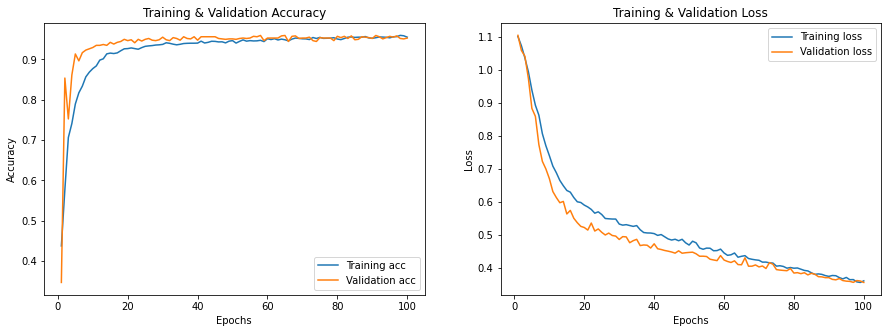

In [50]:
learn_curves(history4)

37/37 [==============================] - 0s 9ms/step


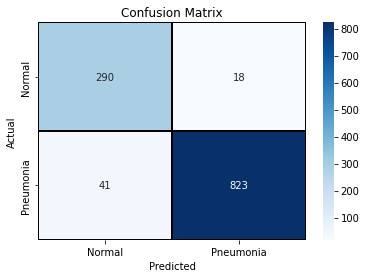

37/37 [==============================] - 0s 11ms/step - loss: 0.3631 - accuracy: 0.9497
[0.3630644381046295, 0.9496586918830872]


In [51]:
evaluation(cnn4)

Now we might have a different issue--underfitting. We'll keep the additional data provided by the preprocessing layer, and increase the complexity.

##  **Model 5**

In [52]:
cnn5 = keras.Sequential()

cnn5.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn5.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn5.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D(2, 2))

cnn5.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn5.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D(2, 2))

cnn5.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn5.add(layers.Conv2D(64, (3, 3), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn5.add(layers.MaxPooling2D(2, 2))

cnn5.add(layers.Flatten())
cnn5.add(layers.Dense(128, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn5.add(layers.Dropout(0.5))
cnn5.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(1e-6)
cnn5.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn5.build(input_shape=(None, 256, 256, 3))
cnn5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_1 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_9 (Conv2D)           (None, 252, 252, 8)       608       
                                                                 
 conv2d_10 (Conv2D)          (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 123, 123, 16)      2320      
                                                                 
 conv2d_12 (Conv2D)          (None, 121, 121, 32)     

In [56]:
history5 = cnn5.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100
59/59 [==============================] - 17s 284ms/step - loss: 3.5600 - accuracy: 0.4027 - val_loss: 3.5608 - val_accuracy: 0.4440
Epoch 2/100
59/59 [==============================] - 17s 283ms/step - loss: 3.5221 - accuracy: 0.5620 - val_loss: 3.5227 - val_accuracy: 0.5507
Epoch 3/100
59/59 [==============================] - 17s 282ms/step - loss: 3.4863 - accuracy: 0.5954 - val_loss: 3.4857 - val_accuracy: 0.6457
Epoch 4/100
59/59 [==============================] - 17s 282ms/step - loss: 3.4506 - accuracy: 0.6293 - val_loss: 3.4455 - val_accuracy: 0.7620
Epoch 5/100
59/59 [==============================] - 17s 282ms/step - loss: 3.4126 - accuracy: 0.6467 - val_loss: 3.4121 - val_accuracy: 0.7599
Epoch 6/100
59/59 [==============================] - 17s 280ms/step - loss: 3.3770 - accuracy: 0.7064 - val_loss: 3.3732 - val_accuracy: 0.8122
Epoch 7/100
59/59 [==============================] - 17s 284ms/step - loss: 3.3404 - accuracy: 0.7670 - val_loss: 3.3411 - val_accuracy:

Final Training Accuracy: 0.9025887250900269
Final Validation Accuracy: 0.9327641129493713


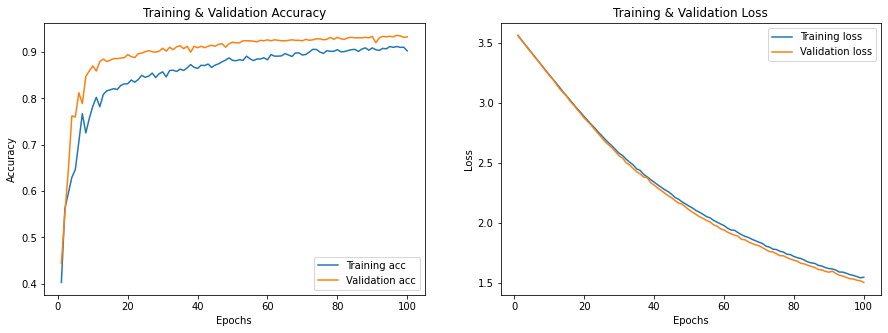

In [57]:
learn_curves(history5)

In [58]:
def evaluation(model):
    predictions = (model.predict(X_test) > 0.5)*1
    cm = confusion_matrix(y_test, predictions)

    df_cm = pd.DataFrame(cm.T, index=['Pneumonia', 'Normal'],
                         columns=['Pneumonia', 'Normal'])
    sns.heatmap(df_cm.T, annot=True, fmt='d', cmap='Blues',
                linecolor='black', linewidths=1)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.ylim(0, 2)
    plt.xlim(2, 0)
    plt.show()

    print(model.evaluate(X_test, y_test))

37/37 [==============================] - 0s 11ms/step


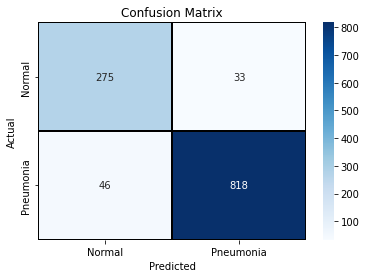

37/37 [==============================] - 0s 12ms/step - loss: 1.5080 - accuracy: 0.9326
[1.5080455541610718, 0.9325938820838928]


In [59]:
evaluation(cnn5)

That created a few more false negatives than I'm confortable with. Generally speaking, the balance between bias and variance is going to be situation-dependent. In some instances, having more false positives is preferable to false negatives, such as here.

For medical situations, it's better to treat an illness that isn't there than to miss an illness that actually is there. So we want to minimize our false negatives as much as we can.

##  **Model 6**

In [60]:
cnn6 = keras.Sequential()

cnn6.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn6.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn6.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D(2, 2))

cnn6.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn6.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D(2, 2))

cnn6.add(layers.Conv2D(64, (3, 3), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn6.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn6.add(layers.Dropout(0.5))
cnn6.add(layers.MaxPooling2D(2, 2))

cnn6.add(layers.Flatten()),
cnn6.add(layers.Dense(256, activation='relu')),
cnn6.add(layers.Dropout(0.5))
cnn6.add(layers.Dense(1, activation='sigmoid'))


opt = keras.optimizers.Adam(1e-5)
cnn6.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn6.build(input_shape=(None, 256, 256, 3))
cnn6.summary()

(None,)

(None,)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 32)      4

In [61]:
opt = keras.optimizers.Adam(1e-6)

cnn6.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn6.build(input_shape=(None, 256, 256, 3))
cnn6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 32)      4

In [62]:
history6 = cnn6.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100


59/59 [==============================] - 19s 298ms/step - loss: 1.1198 - accuracy: 0.4529 - val_loss: 1.1184 - val_accuracy: 0.5112
Epoch 2/100
59/59 [==============================] - 17s 289ms/step - loss: 1.0949 - accuracy: 0.6069 - val_loss: 1.1035 - val_accuracy: 0.8282
Epoch 3/100
59/59 [==============================] - 17s 288ms/step - loss: 1.0694 - accuracy: 0.6971 - val_loss: 1.0826 - val_accuracy: 0.8954
Epoch 4/100
59/59 [==============================] - 17s 287ms/step - loss: 1.0450 - accuracy: 0.7491 - val_loss: 1.0590 - val_accuracy: 0.8869
Epoch 5/100
59/59 [==============================] - 17s 287ms/step - loss: 1.0158 - accuracy: 0.7889 - val_loss: 1.0607 - val_accuracy: 0.8687
Epoch 6/100
59/59 [==============================] - 17s 290ms/step - loss: 0.9857 - accuracy: 0.8193 - val_loss: 1.0369 - val_accuracy: 0.8901
Epoch 7/100
59/59 [==============================] - 17s 287ms/step - loss: 0.9566 - accuracy: 0.8140 - val_loss: 1.0179 - val_accuracy: 0.8954
Epoc

Final Training Accuracy: 0.9351481199264526
Final Validation Accuracy: 0.9455709457397461


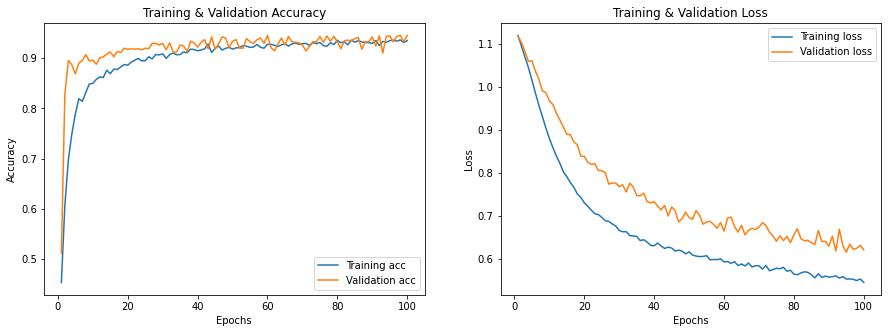

In [63]:
learn_curves(history6)

37/37 [==============================] - 1s 11ms/step


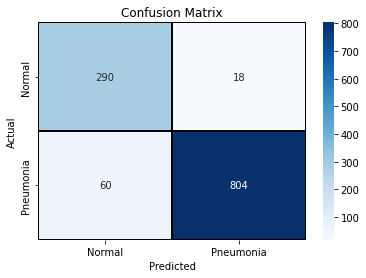

37/37 [==============================] - 0s 12ms/step - loss: 0.6287 - accuracy: 0.9334
[0.628739058971405, 0.9334471225738525]


In [64]:
evaluation(cnn6)

That didn't quite work as expected. Bias-variance tradeoff strikes again. 

Let's increase both complexity and regularization.

In [ ]:
keras.backend.clear_session()


In [ ]:
callbacks = EarlyStopping(monitor='val_loss',min_delta=0, mode='auto', patience=10)

## **Model 7**

Here we will increase number of filters in all layers, regularize the final conv layer and both dense layers, and dropout just before and after flatten.

In [87]:
from keras.callbacks import ModelCheckpoint
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)

In [88]:
cnn7 = keras.Sequential()

cnn7.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn7.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn7.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D(2, 2))

cnn7.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn7.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D(2, 2))

cnn7.add(layers.Conv2D(128, (3, 3), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn7.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn7.add(layers.Dropout(0.5))
cnn7.add(layers.MaxPooling2D(2, 2))

cnn7.add(layers.Flatten())
cnn7.add(layers.Dense(256, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn7.add(layers.Dense(512, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn7.add(layers.Dropout(0.5))
cnn7.add(layers.Dense(1, activation='sigmoid'))

In [89]:
opt = keras.optimizers.Adam(1e-5)

cnn7.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn7.build(input_shape=(None, 256, 256, 3))
cnn7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_5 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_42 (Conv2D)          (None, 252, 252, 16)      1216      
                                                                 
 conv2d_43 (Conv2D)          (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 conv2d_45 (Conv2D)          (None, 121, 121, 64)     

In [90]:
history7 = cnn7.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/100


59/59 [==============================] - 21s 319ms/step - loss: 9.5448 - accuracy: 0.5506 - val_loss: 9.0281 - val_accuracy: 0.8890
Epoch 2/100
59/59 [==============================] - 18s 309ms/step - loss: 8.4950 - accuracy: 0.8062 - val_loss: 8.0763 - val_accuracy: 0.8997
Epoch 3/100
59/59 [==============================] - 18s 307ms/step - loss: 7.6276 - accuracy: 0.8639 - val_loss: 7.4026 - val_accuracy: 0.8741
Epoch 4/100
59/59 [==============================] - 18s 306ms/step - loss: 7.0212 - accuracy: 0.8727 - val_loss: 6.8122 - val_accuracy: 0.9210
Epoch 5/100
59/59 [==============================] - 18s 309ms/step - loss: 6.5263 - accuracy: 0.8940 - val_loss: 6.3928 - val_accuracy: 0.9125
Epoch 6/100
59/59 [==============================] - 18s 307ms/step - loss: 6.1426 - accuracy: 0.8922 - val_loss: 6.0164 - val_accuracy: 0.9328
Epoch 7/100
59/59 [==============================] - 18s 306ms/step - loss: 5.8027 - accuracy: 0.8962 - val_loss: 5.7054 - val_accuracy: 0.9306
Epoc

Final Training Accuracy: 0.9850547313690186
Final Validation Accuracy: 0.9573105573654175


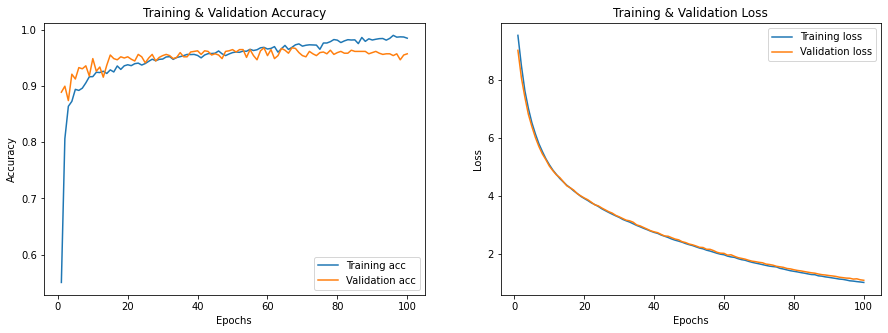

In [91]:
learn_curves(history7)

37/37 [==============================] - 1s 17ms/step


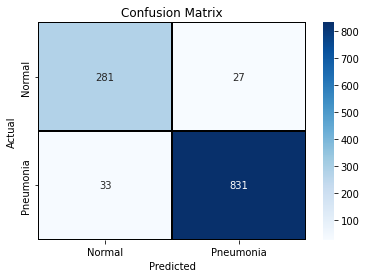

37/37 [==============================] - 1s 15ms/step - loss: 1.0933 - accuracy: 0.9488
[1.0932655334472656, 0.9488054513931274]


In [92]:
evaluation(cnn7)

# **Evaluation**

CNN7, though its validation and test accuracies were not the highest, minimized the number of false negatives and seemed to generalize better than the other models. Using a complex model to pick up as many features as possible, while using regularization to keep weights in check, seems to strike the right balance between generalization and error rate. 

The biggest drawback is the preprocessing layer adding a not-so-insignificant chunk of computation time. Callbacks helped, but min_delta should probably be higher.

The model features two blocks of two stacks of conv2d layers with max pooling, a third such block with the first convolutional layer l2 regularized and dropout on the second at 50%.

All filters are doubled in number from previous iteration, and filter sizes remain the same.

In [93]:
from keras.models import load_model

cnn7.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del cnn7  # deletes the existing model

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

In [94]:
final = models.load_model('my_model.h5')

In [95]:
final.evaluate(X_train, y_train)

147/147 [==============================] - 3s 16ms/step - loss: 1.0387 - accuracy: 0.9842


[1.0387223958969116, 0.9842015504837036]

37/37 [==============================] - 1s 14ms/step


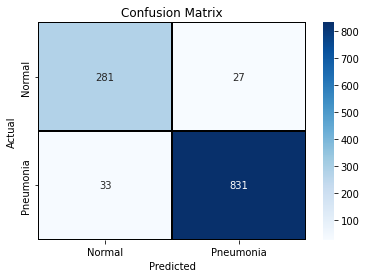

37/37 [==============================] - 1s 15ms/step - loss: 1.0933 - accuracy: 0.9488
[1.0932655334472656, 0.9488054513931274]


In [101]:
test_pred = final.predict((X_test<=0.49999)*1)
evaluation(final)



In [99]:
from sklearn.metrics import classification_report
classification_report(y_test, test_preds)

ValueError: ignored

# **Recommendations**

1. Positive cases should be confirmed by trained medical personnel

2. Expand training with wider patient dataset (current Xrays were taken only from pediatric patients)

3. At almost 95% accuracy with 97% recall, the results can be relied upon to flag positive pneumonia cases. 

4. Perfect for urgent care clinics and emergency departments where the potential exists for high volume and necessitates quick turn around.